In [6]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(font_scale=1.2)
# Function `set` is deprecated in favor of `set_theme`
# https://seaborn.pydata.org/generated/seaborn.set_theme.html

print('Automobilių kainos vertinimas.\nAntroji projekto versija.')

# Šis failas:
# /home/administratorius/git/python_kursai/DataScienceNotebooks/Studentai/MykolasOK/2024-11-13_autop.ipynb
# Duomenų šaltiniai:
# /home/administratorius/git/python_kursai/DataScienceNotebooks/DATA/atlyginimai.csv (-)
# /home/administratorius/git/python_kursai/DataScienceNotebooks/DATA/WEBscr.db (+)

Automobilių kainos vertinimas.
Antroji projekto versija.


In [ ]:
import re
from datetime import datetime

def extract_year(date_str):
    if not date_str:
        return None  # Grąžiname None, jei eilutė tuščia ar None
    
    # Reguliarioji išraiška, ieškanti metų ISO formato datos dalyje (YYYY-MM-DD arba YYYY-MM)
    match = re.search(r'\b(\d{4})\b', date_str)
    
    if match:
        year = int(match.group(1))
    
        # Patikriname, ar metai atitinka protingą intervalą (pvz., nuo 1000 iki dabartinių metų)
        current_year = datetime.now().year
        if 1900 < year < current_year+2:
            return year

    return None  # Grąžiname None, jei metų rasti nepavyko

# print(extract_year("2023-05-12"))  # rezultatas: 2023
# print(extract_year("2020-05"))     # rezultatas: 2023
# print(extract_year("1999"))        # rezultatas: 1999
# print(extract_year("nėra datos"))  # rezultatas: None
# print(extract_year(""))            # rezultatas: None
# print(extract_year("9999-12-31"))  # rezultatas: None

2023
2020
1999
None
None
None


In [7]:
print("Automobilių duomenys paimami iš DB failo")
conn = sqlite3.connect('../../DATA/WEBscr.db')
# query = "SELECT name FROM sqlite_master WHERE type='table';"
# print(pd.read_sql_query(query, conn)['name'].tolist())
query = '''SELECT TAutos.*, TUrl.url, TUrl.name, TUrl.params
            FROM TAutos
            LEFT JOIN TUrl ON TAutos.id = TUrl.id
            GROUP BY TAutos.id;'''
df=pd.read_sql_query(query, conn)
# print(df.columns,end='\n')

Automobilių duomenys paimami iš DB failo


In [77]:
import pandas as pd

# Funkcija, kuri ištraukia kainą, galią ir tūrį iš 'params' lauko
def extract_values(params):
    kaina = None
    galia = None
    turis = None
    gdata = None
    miestas = None
    
    # Konvertuojame į mažąsias raides ir skirstome pagal ';' ir ',' kaip laukų atskyriklius
    laukeliai = params.lower().replace(';', ',').split(',')
    for laukas in laukeliai:
        laukas = laukas.strip()
        
        # Paieška kainos su '€'
        if '€' in laukas:
            try:
                kaina = int(laukas.replace('€', '').replace(' ', '').strip())
            except ValueError:
                pass  # Jei negalima konvertuoti, praleidžiame
            
        # Paieška galios su 'kW'
        elif 'kw' in laukas:
            try:
                galia = int(laukas.replace('kw', '').replace(' ', '').strip())
            except ValueError:
                pass
            
        # Paieška tūrio su 'l.'
        elif 'l.' in laukas:
            try:
                turis = float(laukas.replace('l.', '').replace(' ', '').strip())
            except ValueError:
                pass

        # Metų paieška
        else:
            year_find = extract_year(laukas)
            if year_find:
                gdata = year_find
            else:
                miestas=laukas
    
    return pd.Series([kaina, galia, turis, gdata, miestas])

# Pridedame naujus stulpelius: 'kaina_', 'galia_' ir 'turis_'
df[['kaina_','galia_','turis_','gdata_','miestas_']] = df['params'].apply(extract_values)

In [78]:
# Atvaizduojame pirmuosius 7 įrašus su pasirinktais stulpeliais
pd.set_option('display.max_colwidth', None)
print(df[['params','kaina_','galia_','turis_','gdata_','miestas_']].head(11))

                                                                                                        params  \
0    Iveco Daily;2015-12;Krovininis mikroautobusas;Dyzelinas;Mechaninė;2.3 l., 93kW;250 000 km;Kaunas;11 220 €   
1                      Mercedes-Benz E300;1988;Sedanas;Benzinas;Mechaninė;3.0 l., ;200 000 km;Kuršėnai;9 600 €   
2   Infiniti FX37;2010-04;Visureigis / Krosoveris;Benzinas;Automatinė;3.7 l., 235kW;300 000 km;Vilnius;9 999 €   
3                Peugeot Partner;2007-02;Komercinis;Dyzelinas;Mechaninė;2.0 l., 66kW;279 500 km;Alytus;1 700 €   
4     Nissan X-Trail;2017;Visureigis / Krosoveris;Benzinas;Automatinė;2.5 l., 127kW;100 000 km;Akmenė;13 700 €   
5                          Audi S5;2019-01;Sedanas;Benzinas;Automatinė;3.0 l., 260kW;80 000 km;Kaunas;36 700 €   
6             Fiat Ducato;2022-05;Krovininis mikroautobusas;Dyzelinas;Mechaninė;2.3 l., 130kW;Vilnius;42 500 €   
7               Chevrolet Corvette;1981-06;Kabrioletas;Benzinas;Automatinė;5.7 l., ;148 

In [66]:
import pandas as pd
import re

# Funkcija, kuri ištraukia int tipo skaičių iš 'CO₂ emisija, g/km' lauko
def extract_co2(emisija):
    if emisija is None:
        return None  # Grąžiname None, jei emisija yra None

    # Naudojame reguliariąją išraišką, kad rastume pirmą skaičių sekoje
    match = re.search(r'\b\d+\b', emisija.replace(',', ''))
    if match:
        co2_value = int(match.group())
        
        # Patikriname, ar skaičius yra intervale [1, 10000]
        if 1 <= co2_value <= 10000:
            return co2_value

    return None  # Grąžiname None, jei tinkamos reikšmės nėra

# Taikome funkciją kiekvienam 'CO₂ emisija, g/km' įrašui ir rezultatą įrašome į naują stulpelį 'co2_'
df['co2_'] = df['CO₂ emisija, g/km'].apply(extract_co2)

In [ ]:
print(df[['CO₂ emisija, g/km','co2_']].head(14))

   CO₂ emisija, g/km   co2_
0               None    NaN
1               None    NaN
2               None    NaN
3         ~ 152 g/km  152.0
4               None    NaN
5               None    NaN
6               None    NaN
7               None    NaN
8         ~ 299 g/km  299.0
9               None    NaN
10              None    NaN
11          294 g/km  294.0
12              None    NaN
13          119 g/km  119.0


In [64]:
df['apžiūra_'] = df['Tech. apžiūra iki'].apply(extract_year)

In [65]:
print(df[['Tech. apžiūra iki', 'apžiūra_']].head(10))

  Tech. apžiūra iki  apžiūra_
0              None       NaN
1              None       NaN
2           2026-01       NaN
3           2021-05    2021.0
4           2025-07    2025.0
5              2026       NaN
6              None       NaN
7              None       NaN
8              None       NaN
9              None       NaN


In [84]:
df1=df[['id','gamintojas','kaina_','galia_','turis_','gdata_','miestas_','apžiūra_','co2_']]

In [85]:
df1.head(15)

,id,gamintojas,kaina_,galia_,turis_,gdata_,miestas_,apžiūra_,co2_
0,10481001,Iveco,11220.0,93.0,2.3,2015,kaunas,NaN,NaN
1,10538831,Mercedes-Benz,9600.0,NaN,3.0,1988,kuršėnai,NaN,NaN
2,10668165,Infiniti,9999.0,235.0,3.7,2010,vilnius,NaN,NaN
3,11068939,Peugeot,1700.0,66.0,2.0,2007,alytus,2021.0,152.0
4,11317191,Nissan,13700.0,127.0,2.5,2017,akmenė,2025.0,NaN
5,11346903,Audi,36700.0,260.0,3.0,2019,kaunas,NaN,NaN
6,11502529,Fiat,42500.0,130.0,2.3,2022,vilnius,NaN,NaN
7,11559075,Chevrolet,12900.0,NaN,5.7,1981,kaunas,NaN,NaN
8,11962101,Mercedes-Benz,8950.0,NaN,5.0,2002,panevėžys,NaN,299.0
9,12552143,Maserati,7000.0,206.0,2.8,2001,panevėžys,NaN,NaN


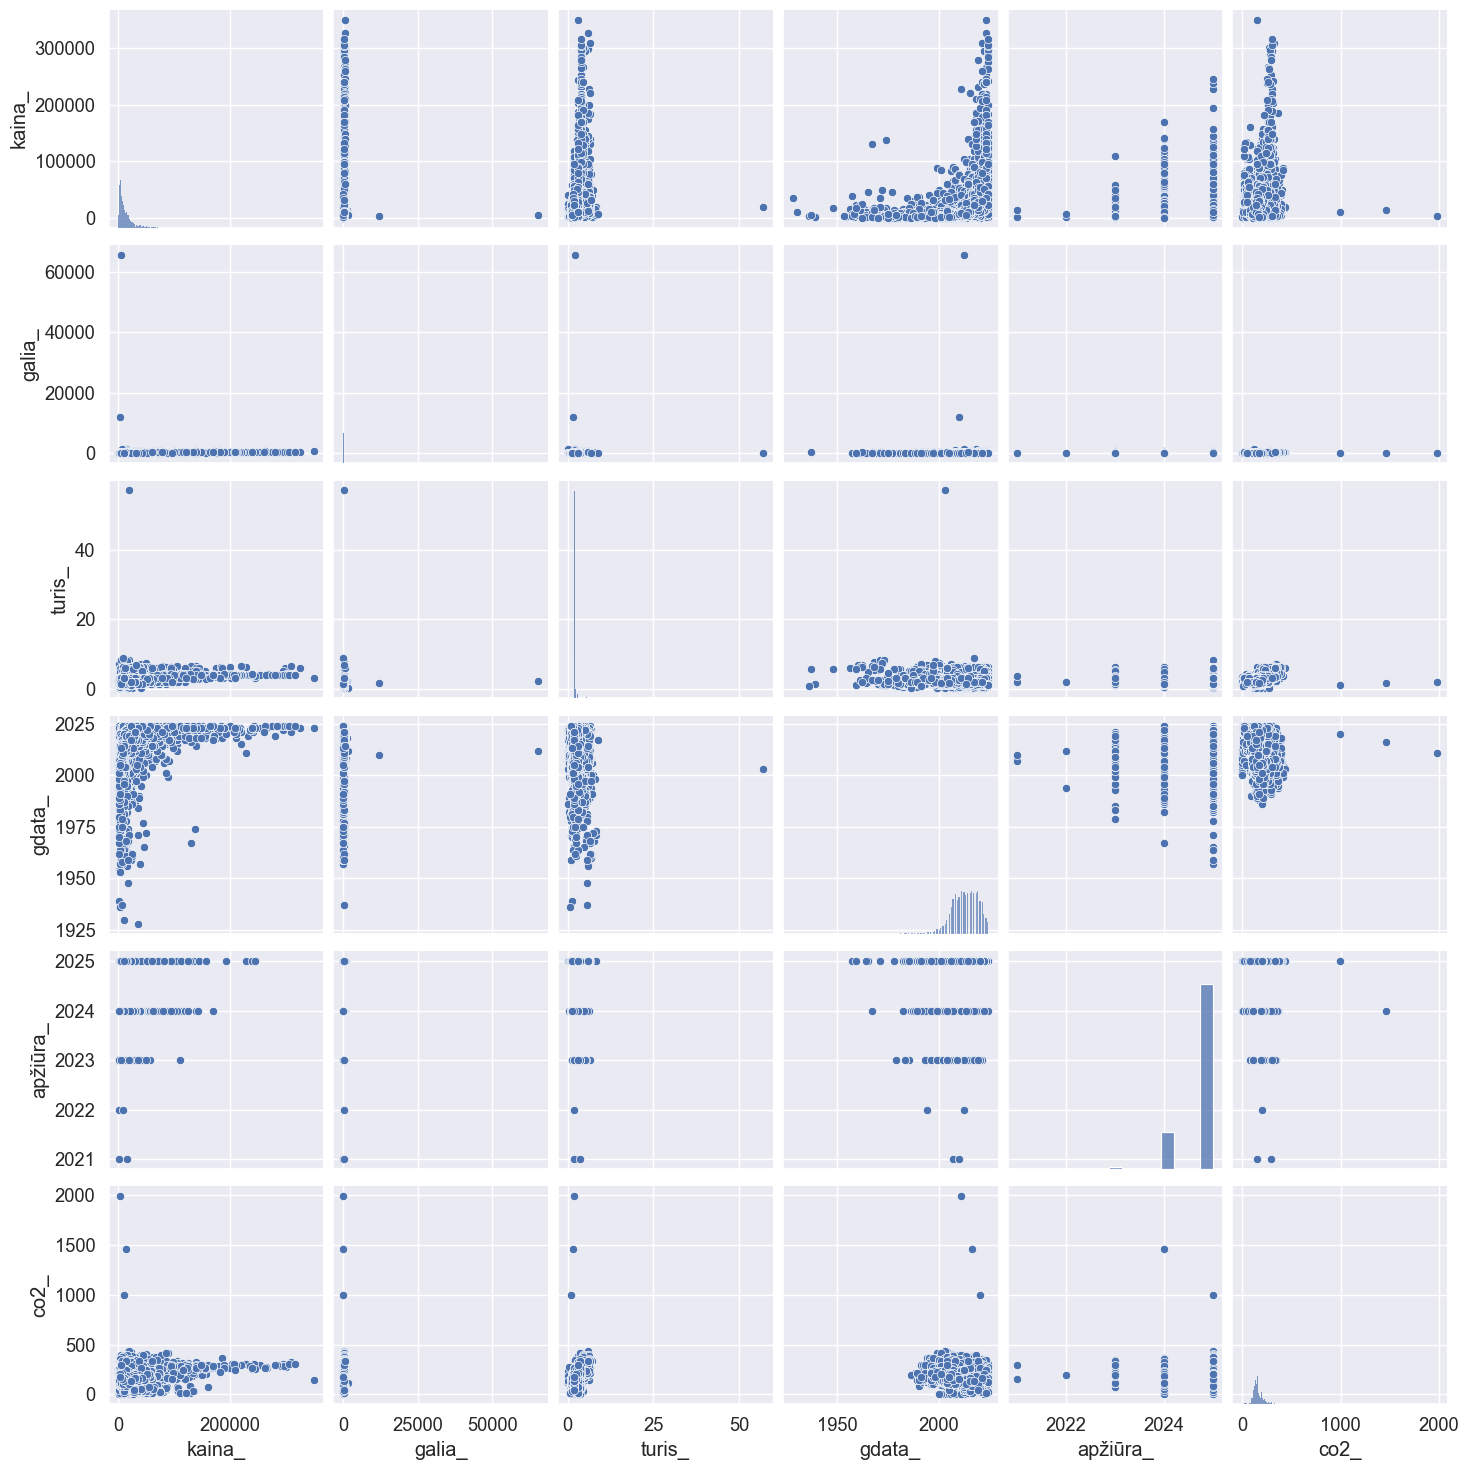

In [86]:
sns.pairplot(data=df1)

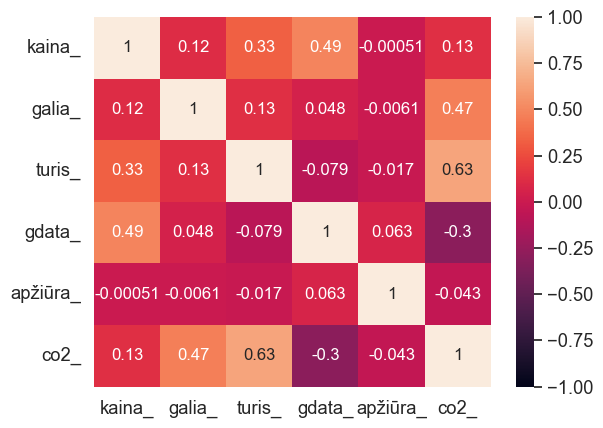

In [89]:
c = df1.corr(numeric_only=True,method='pearson')
ax = sns.heatmap(data=c,annot=True,annot_kws={'fontsize':12},vmin=-1,vmax=1)